# Estimating how active actors will be

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
if int(pd.__version__.split('.')[1]) < 24:
  ! pip install pandas --upgrade

In [3]:
! wget "https://datasets.imdbws.com/title.principals.tsv.gz"
! wget "https://datasets.imdbws.com/title.basics.tsv.gz"
! wget "https://datasets.imdbws.com/name.basics.tsv.gz"

--2019-04-07 17:54:25--  https://datasets.imdbws.com/title.principals.tsv.gz
Resolving datasets.imdbws.com (datasets.imdbws.com)... 143.204.181.54, 143.204.181.48, 143.204.181.2, ...
Connecting to datasets.imdbws.com (datasets.imdbws.com)|143.204.181.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 280869884 (268M) [binary/octet-stream]
Saving to: ‘title.principals.tsv.gz.1’

title.principals.ts 100%[===================>] 267.86M  19.7MB/s    in 14s     

2019-04-07 17:54:39 (18.6 MB/s) - ‘title.principals.tsv.gz.1’ saved [280869884/280869884]

--2019-04-07 17:54:40--  https://datasets.imdbws.com/title.basics.tsv.gz
Resolving datasets.imdbws.com (datasets.imdbws.com)... 143.204.181.54, 143.204.181.48, 143.204.181.2, ...
Connecting to datasets.imdbws.com (datasets.imdbws.com)|143.204.181.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 103416145 (99M) [binary/octet-stream]
Saving to: ‘title.basics.tsv.gz’

title.basics.tsv.gz 100%[

In [0]:
! gunzip title.principals.tsv.gz
! gunzip title.basics.tsv.gz
! gunzip name.basics.tsv.gz

In [0]:
cast = pd.read_csv('title.principals.tsv', sep='\t', na_values = "\\N", keep_default_na = False, 
                   usecols = ['tconst','ordering','nconst','category','job'],
                   dtype = {'tconst': str, 'ordering': 'Int64', 'nconst': str, 'category': str, 'job': str})
titles = pd.read_csv('title.basics.tsv', sep='\t', na_values = "\\N", keep_default_na = False,
                     usecols = ['tconst','primaryTitle','startYear'],
                    dtype = {'tconst': str, 'primaryTitle': str, 'startYear': 'Int64'})
names = pd.read_csv('name.basics.tsv', sep='\t', na_values = "\\N", keep_default_na = False,
                    usecols = ['nconst','primaryName','birthYear','deathYear'],
                   dtype = {'nconst': str, 'primaryName': str, 'birthYear': 'Int64', 'deathYear': 'Int64'})

In [0]:
startYear = 1950
endYear = 1960

In [6]:
cast.head()

,tconst,ordering,nconst,category,job
0,tt0000001,1,nm1588970,self,NaN
1,tt0000001,2,nm0005690,director,NaN
2,tt0000001,3,nm0374658,cinematographer,director of photography
3,tt0000002,1,nm0721526,director,NaN
4,tt0000002,2,nm1335271,composer,NaN


In [7]:
titles.head()

,tconst,primaryTitle,startYear
0,tt0000001,Carmencita,1894
1,tt0000002,Le clown et ses chiens,1892
2,tt0000003,Pauvre Pierrot,1892
3,tt0000004,Un bon bock,1892
4,tt0000005,Blacksmith Scene,1893


In [8]:
names.head()

,nconst,primaryName,birthYear,deathYear
0,nm0000001,Fred Astaire,1899,1987
1,nm0000002,Lauren Bacall,1924,2014
2,nm0000003,Brigitte Bardot,1934,NaN
3,nm0000004,John Belushi,1949,1982
4,nm0000005,Ingmar Bergman,1918,2007


In [0]:
actors = ["Lauren Bacall", "Cary Grant", "Ingrid Bergman", "James Stewart"]

In [0]:
names_actors = names[names.primaryName.isin(actors)].head(len(actors))

In [0]:
names_actors = names_actors[names_actors.deathYear >= endYear]

In [31]:
names_actors

,nconst,primaryName,birthYear,deathYear
1,nm0000002,Lauren Bacall,1924,2014
5,nm0000006,Ingrid Bergman,1915,1982
25,nm0000026,Cary Grant,1904,1986
70,nm0000071,James Stewart,1908,1997


In [0]:
cast_actors = pd.merge(names_actors, cast, on = 'nconst')

In [0]:
movie_actors = pd.merge(cast_actors, titles, on = 'tconst')

In [0]:
movie_list = movie_actors[['primaryName','birthYear','deathYear','category','primaryTitle','startYear']]

In [0]:
movie_list = movie_list[movie_list.category.isin(['actor','actress'])]

In [28]:
movie_list.head()

,primaryName,birthYear,deathYear,category,primaryTitle,startYear
0,Lauren Bacall,1924,2014,actress,To Have and Have Not,1944
1,Lauren Bacall,1924,2014,actress,Confidential Agent,1945
2,Lauren Bacall,1924,2014,actress,The Big Sleep,1946
3,Lauren Bacall,1924,2014,actress,Dark Passage,1947
4,Lauren Bacall,1924,2014,actress,Key Largo,1948


In [0]:
movie_list_observed = movie_list[movie_list.startYear.isin(range(startYear,endYear))]
movie_list_unobserved = movie_list[movie_list.startYear >= endYear]

In [0]:
movie_counts = movie_list_observed.groupby(['primaryName','startYear']).agg({'primaryTitle': 'count'}).reset_index().rename(columns = {'primaryTitle':'numberMovies'})

In [20]:
movie_counts.groupby('primaryName').agg({'numberMovies':'sum'})

,numberMovies
primaryName,
Cary Grant,13
Ingrid Bergman,12
James Stewart,27
Lauren Bacall,13


In [29]:
movie_counts.head()

,primaryName,startYear,numberMovies
0,Cary Grant,1950,1
1,Cary Grant,1951,1
2,Cary Grant,1952,2
3,Cary Grant,1953,1
4,Cary Grant,1955,1


In [0]:
def plot_history_actor(ax, actor_name, max_value):
  actor_history = movie_counts[movie_counts.primaryName == actor_name]
  ax.bar(actor_history.startYear, actor_history.numberMovies, color = 'firebrick')
  ax.set_xticks([i for i in range(1950,1960)])
  ax.set_yticks(np.linspace(0,max_value,max_value+1))
  ax.set_title(actor_name)
  ax.set_facecolor("linen")

def plot_history_actors(actors):
  n = len(actors)
  k = round(n/3+0.5)
  max_value = movie_counts[movie_counts.primaryName.isin(actors)].numberMovies.max()
  fig, axes = plt.subplots(k,3, figsize = (15,4))
  for ax, actor_name in zip(axes.ravel(), actors):
    plot_history_actor(ax, actor_name, max_value)
  for i in range(n,k*3):
    fig.delaxes(axes.ravel()[i])
  fig.suptitle("Number of movies made each year", y = 1.1, fontsize = 20)
  fig.tight_layout()

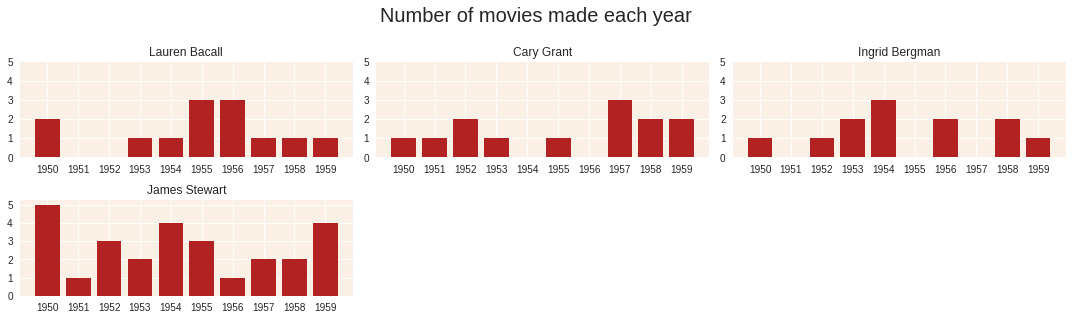

In [27]:
plot_history_actors(actors)

In [0]:
lambda_actors = movie_counts.groupby("primaryName").agg({"numberMovies" : "sum"}).reset_index()
lambda_actors["lambda"] = lambda_actors.numberMovies/(endYear - startYear)

In [53]:
lambda_actors

,primaryName,numberMovies,lambda
0,Cary Grant,13,1.3
1,Ingrid Bergman,12,1.2
2,James Stewart,27,2.7
3,Lauren Bacall,13,1.3


In [0]:
def probability(lambda_param, t, k):
  return np.exp(-lambda_param*t)*(lambda_param*t)**k/np.math.factorial(k)

In [0]:
def plot_probability_actor(ax, actor_name, t):
  lambda_param = lambda_actors[lambda_actors.primaryName == actor_name]["lambda"].iloc[0]
  k_list = np.linspace(0,40,41)
  probability_list = np.array([probability(lambda_param, t, k) for k in k_list])
  ax.plot(k_list, probability_list, color = 'firebrick')
  ax.fill_between(k_list, probability_list,  color = 'firebrick', alpha = 0.5)
  ax.axvline(x=lambda_param*t, color = 'k', linestyle = '--')
  ax.set_title(actor_name)
  ax.set_facecolor("linen")

def plot_probability_actors(actors, t):
  n = len(actors)
  k = round(n/3+0.5)
  max_value = 0.1
  fig, axes = plt.subplots(k,3, figsize = (15,4))
  for ax, actor_name in zip(axes.ravel(), actors):
    plot_probability_actor(ax, actor_name, t)
  for i in range(n,k*3):
    fig.delaxes(axes.ravel()[i])
  fig.suptitle("Fitted probability distribution for t = " + str(t)+ " years", y = 1.1, fontsize = 20)
  fig.tight_layout()

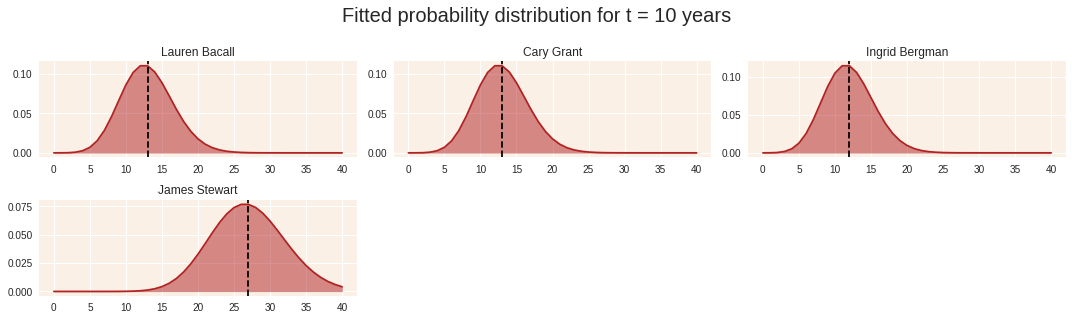

In [150]:
plot_probability_actors(actors, 10)

In [0]:
def cdf(lambda_param, t, n):
  cdf = 0
  for i in range(n):
    cdf += probability(lambda_param, t, i)
  return cdf

In [0]:
def plot_cdf_actor(ax, actor_name, t):
  lambda_param = lambda_actors[lambda_actors.primaryName == actor_name]["lambda"].iloc[0]
  n_list = np.linspace(0,40,41, dtype = int)
  probability_list = np.array([1-cdf(lambda_param, t, n) for n in n_list])
  ax.bar(n_list, probability_list, color = 'firebrick')
  ax.set_yticks(np.linspace(0,1,5))
  ax.set_title(actor_name)
  ax.set_facecolor("linen")

def plot_cdf_actors(actors, t):
  n = len(actors)
  k = round(n/3+0.5)
  max_value = 0.1
  fig, axes = plt.subplots(k,3, figsize = (15,4))
  for ax, actor_name in zip(axes.ravel(), actors):
    plot_cdf_actor(ax, actor_name, t)
  for i in range(n,k*3):
    fig.delaxes(axes.ravel()[i])
  fig.suptitle("Probability of appearing in more than n movies in t = "+ str(t) +" years", y = 1.1, fontsize = 20)
  fig.tight_layout()

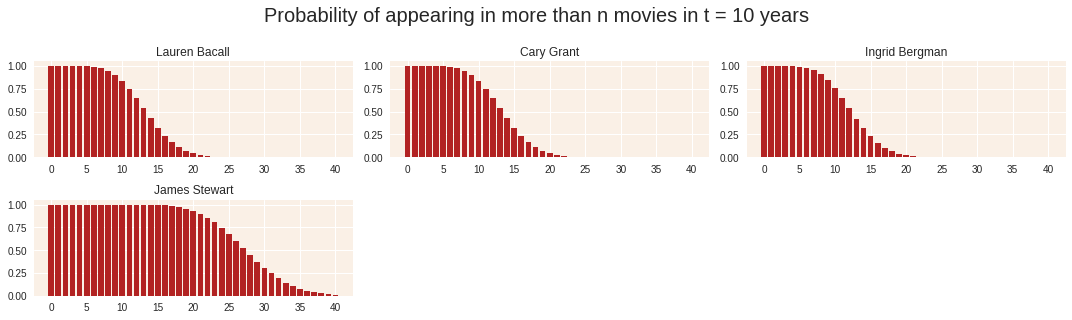

In [148]:
plot_cdf_actors(actors, 10)